# Machine Learning Assessment

## 1. Initialisation

### 1.1. Initialiser

Import calls.

[Performance](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#performance-considerations)

In [1]:
%%writefile init.py

import os
import pandas as pd

def calls_parser(fname) :
    calls_df = pd.read_csv(fname)

    calls_df['Datetime'] = pd.to_datetime(calls_df['Datetime'],\
                                          format="%m/%d/%Y %I:%M:%S %p"\
                                         ).dt.tz_localize(tz='US/Pacific',\
                                                          ambiguous='NaT')

    calls_df.dropna(inplace=True)
    calls_df.set_index('Datetime', inplace=True)
    calls_df.index.set_names('datetime', inplace=True)
    calls_df.sort_index(inplace=True)

    return calls_df

    
def init_calls() :
    # Convert to pandas DataFrame
    
    calls_df_pt = './tmp/calls_df.parquet'
    
    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')
    if os.path.isfile(calls_df_pt) :
        calls_df = pd.read_parquet(calls_df_pt) # pd.read_hdf(calls_df_pt, key='c', mode='r')
        # calls_df.index.to_datetime().dt.tz_convert('US/Pacific')
    else :
        calls_pt = './data/calls.csv'
    
        if not os.path.exists(calls_pt) :
            os.system('cat get_calls.sh | sh')
    
        calls_df = calls_parser(calls_pt)

        calls_df.to_parquet(calls_df_pt) # calls_df.to_hdf(calls_df_pt, key='c', mode='w')

        # results_df['type'] = results_df['type'].astype('category')
    
    return(calls_df)


Overwriting init.py


Import weather data.

In [2]:
%%writefile -a init.py

def weather_parser(fname) :
    wtr_df = pd.read_csv(fname)
    wtr_df['datetime'] = pd.to_datetime(wtr_df['dt'], unit='s').\
                            dt.tz_localize(tz='UTC').\
                            dt.tz_convert('US/Pacific')
    wtr_df.set_index('datetime', inplace=True)
    
    return(wtr_df)


def init_weather() :
    
    wtr_df_pt = './tmp/wtr_df.parquet'
    
    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')
    if os.path.isfile(wtr_df_pt) :
        wtr_df = pd.read_parquet(wtr_df_pt) # wtr_df = pd.read_hdf(wtr_df_pt, key='w', mode='r')
        # wtr_df.index.to_datetime().dt.tz_convert('US/Pacific')
    else :
        wtr_df = weather_parser('./data/Seattle Weatherdata 2002 to 2020.csv')

        wtr_df = wtr_df[~wtr_df.index.duplicated()]

        wtr_df.to_parquet(wtr_df_pt) # wtr_df.to_hdf(wtr_df_pt, key='w', mode='w')

    return(wtr_df)


Appending to init.py


In [3]:
%%writefile -a init.py

def feature_parser(wtr_df) :
    x_raw = wtr_df[['temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id']]
    x_raw = x_raw.index.isocalendar().join(x_raw)
    x_raw.index.set_names('datetime', inplace=True)

    return x_raw

def init() :
    
    xy_df_pt = './tmp/xy_df.parquet'
    
    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')
    if os.path.isfile(xy_df_pt) :
        xy_df = pd.read_parquet(xy_df_pt) # xy_df = pd.read_csv(xy_df_pt, index_col=0) #, key='x', mode='r'
        xy_df.index = pd.to_datetime(xy_df.index,
                                     format='%Y-%m-%d %H:%M:%S',
                                     utc=True).tz_convert('US/Pacific')
    else :
        calls_df = init_calls()
        wtr_df = init_weather()
        
        x_raw = feature_parser(wtr_df)

        # x_raw.drop_duplicates(inplace=True)

        y_raw = calls_df['Incident Number'].resample('H').count().to_frame('incident_count')
        xy_df = y_raw.join(x_raw)
        xy_df.index.set_names('datetime', inplace=True)
        xy_df['hour'] = xy_df.index.hour
        xy_df = xy_df.join(x_raw).dropna()

        xy_df.drop_duplicates(inplace=True)

        xy_df.to_parquet(xy_df_pt) #, key='x', mode='w'

    return xy_df.iloc[:, 1:], xy_df.iloc[:, 0]


Appending to init.py


### 1.2. Unit tester

In [4]:
%%writefile init_te.py

import init
from importlib import reload

def calls_te() :

    reload(init)

    calls_df = init.init_calls()
    print(calls_df.info())
    print(calls_df.head(1))
    # print(calls_df.tail(2))
    # print(calls_df.iloc[calls_df.index.duplicated()])


Overwriting init_te.py


In [5]:
%%writefile -a init_te.py

def weather_te() :

    reload(init)

    wtr_df = init.init_weather()
    print(wtr_df.info())
    print(wtr_df.head(1))
    # print(wtr_df.iloc[wtr_df.index.duplicated(keep=False)])


Appending to init_te.py


In [6]:
%%writefile -a init_te.py

def init_te() :

    reload(init)

    x, y = init.init()
    print(x.info())
    print(x.head(1))
    print(y.head(1))
    # print(x.iloc[x.index.duplicated(keep=False)])


Appending to init_te.py


### 1.3. Unit test

In [7]:
import init_te
from importlib import reload

In [8]:
reload(init_te)
init_te.calls_te()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560241 entries, 2003-11-07 09:30:48-08:00 to 2021-05-17 10:25:00-07:00
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Address          1560241 non-null  object 
 1   Type             1560241 non-null  object 
 2   Latitude         1560241 non-null  float64
 3   Longitude        1560241 non-null  float64
 4   Report Location  1560241 non-null  object 
 5   Incident Number  1560241 non-null  object 
dtypes: float64(2), object(4)
memory usage: 83.3+ MB
None
                                   Address            Type   Latitude  \
datetime                                                                
2003-11-07 09:30:48-08:00  507 W Mercer St  Medic Response  47.624608   

                            Longitude                Report Location  \
datetime                                                               
2003-11-07 09:30:48-08:00 -122.363505

In [9]:
reload(init_te)
init_te.weather_te()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165192 entries, 2001-12-31 16:00:00-08:00 to 2020-11-04 15:00:00-08:00
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   165192 non-null  int64  
 1   dt_iso               165192 non-null  object 
 2   timezone             165192 non-null  int64  
 3   city_name            165192 non-null  object 
 4   lat                  165192 non-null  float64
 5   lon                  165192 non-null  float64
 6   temp                 165192 non-null  float64
 7   feels_like           165192 non-null  float64
 8   temp_min             165192 non-null  float64
 9   temp_max             165192 non-null  float64
 10  pressure             165192 non-null  int64  
 11  sea_level            0 non-null       float64
 12  grnd_level           0 non-null       float64
 13  humidity             165192 non-null  int64  
 14  wind_speed           1

In [10]:
reload(init_te)
init_te.init_te()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148975 entries, 2003-11-07 09:00:00-08:00 to 2020-11-04 15:00:00-08:00
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   year        148975 non-null  UInt32 
 1   week        148975 non-null  UInt32 
 2   day         148975 non-null  UInt32 
 3   hour        148975 non-null  int64  
 4   temp        148975 non-null  float64
 5   pressure    148975 non-null  float64
 6   humidity    148975 non-null  float64
 7   wind_speed  148975 non-null  float64
 8   wind_deg    148975 non-null  float64
 9   weather_id  148975 non-null  float64
dtypes: UInt32(3), float64(6), int64(1)
memory usage: 11.2 MB
None
                           year  week  day  hour  temp  pressure  humidity  \
datetime                                                                     
2003-11-07 09:00:00-08:00  2003    45    5     9  5.62    1018.0      65.0   

                           wind_speed

## 2. Preprocessing

### 2.1. Preprocessor

In [11]:
%%writefile prep.py

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
import sklearn.preprocessing as skl_prep
from sklearn.model_selection import TimeSeriesSplit

def fwd_splitter(n_spi=2, tr_week=261, te_week=52) :
    return TimeSeriesSplit(n_splits=n_spi, max_train_size=tr_week*7*24, test_size=te_week*7*24)


Overwriting prep.py


In [12]:
%%writefile -a prep.py

def nai_splitter() :
    e1_ind = -365*24
    tr_ind = (-365*5-1)*24+e1_ind
    e2_ind = (-365*5-1)*24+2*e1_ind
    return np.arange(tr_ind, e1_ind), np.arange(e1_ind, 0), np.arange(e2_ind, tr_ind)


Appending to prep.py


In [13]:
%%writefile -a prep.py

def prep_ppl() :
    return(Pipeline([
        ('std_scl', skl_prep.StandardScaler())
    ]))


Appending to prep.py


### 2.2. Unit tester

In [14]:
%%writefile prep_te.py

import init
import prep
from importlib import reload


Overwriting prep_te.py


In [15]:
%%writefile -a prep_te.py

def fwe_te() :

    reload(init)
    reload(prep)

    x, y = init.init()
    for tr_ind, te_ind in prep.fwd_splitter().split(x) :
        print(x.iloc[tr_ind].info(), y.iloc[te_ind].head(2), len(y))


Appending to prep_te.py


In [16]:
%%writefile -a prep_te.py

def nai_te() :

    reload(init)
    reload(prep)

    x, y = init.init()
    tr_ind, e1_ind, e2_ind = prep.nai_splitter()

    print(tr_ind, e1_ind, e2_ind)
    print(x.iloc[tr_ind].info(), y.iloc[e1_ind].head(2), y.iloc[e2_ind].head(2),)


Appending to prep_te.py


### 2.3. Unit test

In [17]:
import prep_te
from importlib import reload

In [18]:
reload(prep_te)
prep_te.fwe_te()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2013-11-06 16:00:00-08:00 to 2018-11-07 15:00:00-08:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        43848 non-null  UInt32 
 1   week        43848 non-null  UInt32 
 2   day         43848 non-null  UInt32 
 3   hour        43848 non-null  int64  
 4   temp        43848 non-null  float64
 5   pressure    43848 non-null  float64
 6   humidity    43848 non-null  float64
 7   wind_speed  43848 non-null  float64
 8   wind_deg    43848 non-null  float64
 9   weather_id  43848 non-null  float64
dtypes: UInt32(3), float64(6), int64(1)
memory usage: 3.3 MB
None datetime
2018-11-07 16:00:00-08:00    19
2018-11-07 17:00:00-08:00    20
Name: incident_count, dtype: int64 148975
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2014-11-05 16:00:00-08:00 to 2019-11-06 15:00:00-08:00
Data columns (total 10 columns):
 #   Column    

In [19]:
reload(prep_te)
prep_te.nai_te()

[-52584 -52583 -52582 ...  -8763  -8762  -8761] [-8760 -8759 -8758 ...    -3    -2    -1] [-61344 -61343 -61342 ... -52587 -52586 -52585]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2014-11-05 16:00:00-08:00 to 2019-11-05 15:00:00-08:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        43824 non-null  UInt32 
 1   week        43824 non-null  UInt32 
 2   day         43824 non-null  UInt32 
 3   hour        43824 non-null  int64  
 4   temp        43824 non-null  float64
 5   pressure    43824 non-null  float64
 6   humidity    43824 non-null  float64
 7   wind_speed  43824 non-null  float64
 8   wind_deg    43824 non-null  float64
 9   weather_id  43824 non-null  float64
dtypes: UInt32(3), float64(6), int64(1)
memory usage: 3.3 MB
None datetime
2019-11-05 16:00:00-08:00    19
2019-11-05 17:00:00-08:00    15
Name: incident_count, dtype: int64 datetime
2013-11-05 16:00:00-08:00    10

## 3. Modelling

### 3.1. Estimator

In [20]:
%%writefile model.py

from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import prep

def model_ppl(rseed=0) :
    return Pipeline([
        ('preprocessor', prep.prep_ppl()),
        ('regressor', GradientBoostingRegressor(random_state=rseed))
    ])
    

Overwriting model.py


### 3.2. Unit tester

In [21]:
%%writefile model_te.py

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import init
import prep
import model
from importlib import reload

def model_fwd_te(n_spi=2) :

    reload(init)
    reload(prep)
    reload(model)

    x, y = init.init()

    mod = model.model_ppl()
    print(mod.get_params())

    for tr_ind, te_ind in prep.fwd_splitter(n_spi=n_spi).split(x) :
        x_tr, y_tr = x.iloc[tr_ind], y.iloc[tr_ind]
        x_te, y_te = x.iloc[te_ind], y.iloc[te_ind]

        mod.fit(x_tr, y_tr)

        y_pd = mod.predict(x_te)

        print(mod.score(x_te, y_te))

        print(np.sqrt(mean_squared_error(y_te, y_pd)))

        pd.DataFrame(data=y_pd, index=y_te.index, columns=['prediction']).join(y_te).resample('W').sum().plot()
        plt.show()

def model_nai_te() :

    reload(init)
    reload(prep)
    reload(model)

    x, y = init.init()

    mod = model.model_ppl()
    
    print(mod.get_params())

    x, y = init.init()
    tr_ind, e1_ind, e2_ind = prep.nai_splitter()

    mod.fit(x.iloc[tr_ind], y.iloc[tr_ind])

    y_p1 = mod.predict(x.iloc[e1_ind])
    print(mod.score(x.iloc[e1_ind], y.iloc[e1_ind]))
    print(np.sqrt(mean_squared_error(y.iloc[e1_ind], y_p1)))
    pd.DataFrame(data=y_p1, index=y.iloc[e1_ind].index, columns=['prediction']).join(y.iloc[e1_ind]).resample('W').sum().plot()
    plt.show()

    y_p2 = mod.predict(x.iloc[e2_ind])
    print(mod.score(x.iloc[e2_ind], y.iloc[e2_ind]))
    print(np.sqrt(mean_squared_error(y.iloc[e2_ind], y_p2)))
    pd.DataFrame(data=y_p2, index=y.iloc[e2_ind].index, columns=['prediction']).join(y.iloc[e2_ind]).resample('W').sum().plot()
    plt.show()

Overwriting model_te.py


### 3.3. Unit test

{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('std_scl', StandardScaler())])), ('regressor', GradientBoostingRegressor(random_state=0))], 'verbose': False, 'preprocessor': Pipeline(steps=[('std_scl', StandardScaler())]), 'regressor': GradientBoostingRegressor(random_state=0), 'preprocessor__memory': None, 'preprocessor__steps': [('std_scl', StandardScaler())], 'preprocessor__verbose': False, 'preprocessor__std_scl': StandardScaler(), 'preprocessor__std_scl__copy': True, 'preprocessor__std_scl__with_mean': True, 'preprocessor__std_scl__with_std': True, 'regressor__alpha': 0.9, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'friedman_mse', 'regressor__init': None, 'regressor__learning_rate': 0.1, 'regressor__loss': 'ls', 'regressor__max_depth': 3, 'regressor__max_features': None, 'regressor__max_leaf_nodes': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_impurity_split': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regre

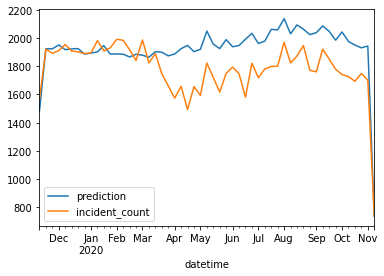

0.44128860145482773
3.67590090158763


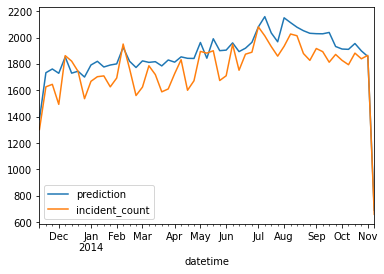

In [22]:
import model_te
from importlib import reload

reload(model_te)

model_te.model_nai_te()

{'memory': None, 'steps': [('preprocessor', Pipeline(steps=[('std_scl', StandardScaler())])), ('regressor', GradientBoostingRegressor(random_state=0))], 'verbose': False, 'preprocessor': Pipeline(steps=[('std_scl', StandardScaler())]), 'regressor': GradientBoostingRegressor(random_state=0), 'preprocessor__memory': None, 'preprocessor__steps': [('std_scl', StandardScaler())], 'preprocessor__verbose': False, 'preprocessor__std_scl': StandardScaler(), 'preprocessor__std_scl__copy': True, 'preprocessor__std_scl__with_mean': True, 'preprocessor__std_scl__with_std': True, 'regressor__alpha': 0.9, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'friedman_mse', 'regressor__init': None, 'regressor__learning_rate': 0.1, 'regressor__loss': 'ls', 'regressor__max_depth': 3, 'regressor__max_features': None, 'regressor__max_leaf_nodes': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_impurity_split': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regre

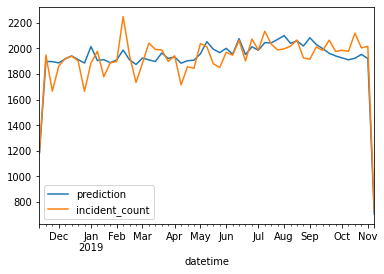

0.3798402747922911
3.7280260993714536


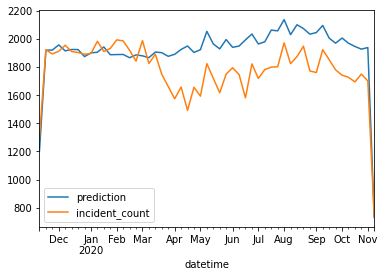

In [23]:
import model_te
from importlib import reload

reload(model_te)

model_te.model_fwd_te(2)

## 4. Training

### 4.1. Alchemist

[parameters](https://stackoverflow.com/a/49501713/2682621)

In [11]:
%%writefile train.py

import os
from sklearn.model_selection import GridSearchCV
import joblib

import init
import prep
import model

def train() :

    if not os.path.exists('./tmp') :
        os.system('mkdir tmp')

    train_pt = './tmp/reg.pkl'
    if os.path.isfile(train_pt) :
        print('Load saved regressor from ' + train_pt)
        reg = joblib.load(train_pt)
    else:
        x, y = init.init()
        tr_ind, e1_ind, e2_ind = prep.nai_splitter()
    
        p_grid = {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [3, 4, 5]
        }

        reg = GridSearchCV(estimator=model.model_ppl(),
                           param_grid=p_grid,
                           n_jobs=-1,
                           verbose=2)

        reg.fit(x.iloc[tr_ind], y.iloc[tr_ind])
        
        joblib.dump(reg, train_pt)
        
    return reg


Overwriting train.py


### 4.2. Unit tester

0.37925153259693567


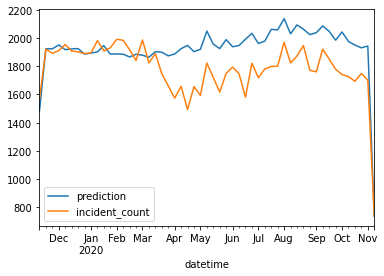

0.44128860145482773


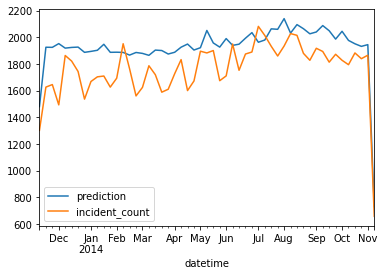

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

import train

reg = train.train()

y_p1 = reg.predict(x.iloc[e1_ind])
print(reg.score(x.iloc[e1_ind], y.iloc[e1_ind]))
pd.DataFrame(data=y_p1, index=x.iloc[e1_ind].index, columns=['prediction']).join(y.iloc[e1_ind]).resample('W').sum().plot()
plt.show()

y_p2 = reg.predict(x.iloc[e1_ind])
print(reg.score(x.iloc[e2_ind], y.iloc[e2_ind]))
pd.DataFrame(data=y_p2, index=x.iloc[e2_ind].index, columns=['prediction']).join(y.iloc[e2_ind]).resample('W').sum().plot()
plt.show()

## 5. Main

In [ ]:
%%writefile main.py

import sys

import init
import train

def main() :
    if len(sys.argv) == 1 or len(sys.argv) > 3 :
        print('usage: python main.py input.csv [calls.csv]')
    else :
        wtr_new = init.weather_parser(sys.argv[1])
        x_new = init.feature_parser(wtr_new)
        reg = train.train()
        y_pew = reg.predict(x_new)
        
        y_pew.to_csv('output.csv')
        
        if len(sys.argv) == 3 :
            calls_new = init.calls_parser()
            y_new = 

if __name__ == '__main__':
    main()